### 자전거 대여 수요 예측 경진대회

날짜, 계절, 근무일 여부, 날씨, 온도, 체감 온도, 풍속 데이터를 활용하여 자전거 대여 수량 예측
- 문제 유형 : 회귀
- 평가 지표 : RMSLE
- 데이터 크기 : 1.1MB
- 제출 시 사용한 모델 : RandomForestRegressor

In [54]:
import pandas as pd, numpy as np

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
sub_data = pd.read_csv("./data/sampleSubmission.csv")

print(train_data.shape, test_data.shape)
print(train_data.isna().sum().sum()) # 결측치 : 0

(10886, 12) (6493, 9)
0


|feature name|explanation|
|---|---|
|datetime|기록 일시(1시간 간격)|
|season|계절(1:봄, 2:여름, 3:가을, 4:겨울)|
|holiday|공휴일 여부(0:공휴일 아님, 1:공휴일)|
|workingday|근무일 여부(0:근무일 아님, 1:근무일) <br> *주말과 공휴일이 아니면 근무일이라고 간주|
|weather|날씨(1:맑음, 2:옅은 안개, 약간 흐림 <br> 3:약간의 눈, 약간의 비와 천둥 번개, 흐림 <br> 4: 폭우와 천둥번개, 눈과 짙은 안개 <br> * 숫자가 클수록 날씨가 안좋음)|
|temp|실제 온도|
|atemp|체감 온도|
|humidity|상대 습도|
|windspeed|풍속|
|casual|등록되지 않은 사용자(비회원) 수|
|registered|등록된 사용자(회원) 수|
|count|자전거 대여 수량|

In [55]:
train_data.head()

# datetime ~ registered : 예측에 사용할 수 있는 features.
# count : 예측해야 할 target값
# datetime의 경우 한 시간 간격으로 기록되어 있다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [56]:
test_data.head()

# 마찬가지로 windspeed까지의 feature를 사용해서 count값을 예측해야 하지만, 테스트 데이터에 casual과 registered feature는 없기 때문에 제외하고 진행.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### 데이터 분석 결과

datetime ~ registered까지는 예측에 사용할 수 있는 features이고, count는 예측해야 할 target값이며, datetime의 경우 한 시간 간격으로 기록되어 있다. 다만, test_data의 features를 살펴보면 casual과 registered라는 feature가 없기 때문에 train_data에서도 casual과 registered를 제외하고 모델을 훈련한다.


### 샘플 제출 파일 살펴보기

In [57]:
sub_data.head()

# 데이터를 구분하는 ID(datetime)값과 타겟값으로 구성되어 있다. 현재는 타겟값이 모두 0인데, 시간대별 대여 수량을 예측해 이 값들을 변경하여 제출한다.

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [58]:
# info()함수를 사용하여 결측치, 데이터 타입을 확인한다.
train_data.info()

# 결측치의 개수는 없는 것으로 확인된다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [59]:
test_data.info()

# 테스트 데이터에도 결측치는 존재하지 않으며, Date type또한 동일하기 때문에 예측을 진행한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### Feature Engineering - 데이터 시각화

데이터를 시각화 하기에 앞서, 수치형 변수가 아닌 datetime에 대한 작업을 진행하다.

In [60]:
# datetime의 type은 object이다. python의 string과 비슷하다고 볼 수 있다. 
# datetime은 연도, 월, 일, 시간, 분, 초로 구성되어 있다.

print(train_data['datetime'][100])
print(train_data['datetime'][100].split())
print(train_data['datetime'][100].split()[0]) # 날짜
print(train_data['datetime'][100].split()[0].split('-')) # 날짜를 -를 기준으로 나눠
print(train_data['datetime'][100].split()[0].split('-')[0]) # 연도
print(train_data['datetime'][100].split()[0].split('-')[1]) # 월
print(train_data['datetime'][100].split()[0].split('-')[2]) # 일을 얻을 수 있다.
print(train_data['datetime'][100].split()[1]) # 시간
print(train_data['datetime'][100].split()[1].split(':')) # 시간을 :를 기준으로 나눠
print(train_data['datetime'][100].split()[1].split(':')[0]) # 시
print(train_data['datetime'][100].split()[1].split(':')[1]) # 분
print(train_data['datetime'][100].split()[1].split(':')[2]) # 초를 얻을 수 있다.

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
['2011', '01', '05']
2011
01
05
09:00:00
['09', '00', '00']
09
00
00


In [61]:
# 다음으로는 apply()함수를 이용해 파생 피처를 생성한다.
train_data['date'] = train_data['datetime'].apply(lambda x : x.split()[0]) # 날짜 피쳐 생성

# 연도, 월, 일, 시, 분, 초 피처를 차례로 생성
train_data['year'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
train_data['month'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
train_data['day'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[2])
train_data['hour'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train_data['minute'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train_data['second'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[2])

In [62]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19,00,00
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20,00,00
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21,00,00
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22,00,00


In [63]:
# 요일 피처를 생성한다. 요일 피처의 경우 calendar와 datetime 라이브러리를 활용해 만들 수 있다.

from datetime import datetime
import calendar

print(train_data['date'][100])
print(datetime.strptime(train_data['date'][100], "%Y-%m-%d")) # datetime 타입으로 변경
# 정수로 요일 변환
print(datetime.strptime(train_data['date'][100], "%Y-%m-%d").weekday()) # weekday() : 요일 반환 메소드
# 문자열로 요일 변환
print(calendar.day_name[datetime.strptime(train_data['date'][100], "%Y-%m-%d").weekday()]) # 0~6의 인덱스에 각 요일 이름이 매핑되어 있음. 2 : 수요일

2011-01-05
2011-01-05 00:00:00
2
Wednesday


In [64]:
# 요일 피처를 추가한다.
train_data['weekday'] = train_data['date'].apply(lambda dateString : calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


In [65]:
# season과 weather 피처의 경우 1, 2, 3, 4라는 정수로만 표시되어 있어 정확한 의미 파악이 어렵다. 시각화 시 의미가 잘 드러나도록 map()함수를 이용해 문자열로 바꾼다.

train_data['season'] = train_data['season'].map({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"})
train_data['weather'] = train_data['weather'].map({1:"Clear", 2:"Mist, Few Clouds", 3:"Light Snow, Train, ThunderStorms", 4:"Heavy Rain, ThunderStorms, Snow, Fog"})

train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0,1,Clear,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19,00,00,Wednesday
10882,2012-12-19 20:00:00,Winter,0,1,Clear,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20,00,00,Wednesday
10883,2012-12-19 21:00:00,Winter,0,1,Clear,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21,00,00,Wednesday
10884,2012-12-19 22:00:00,Winter,0,1,Clear,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22,00,00,Wednesday


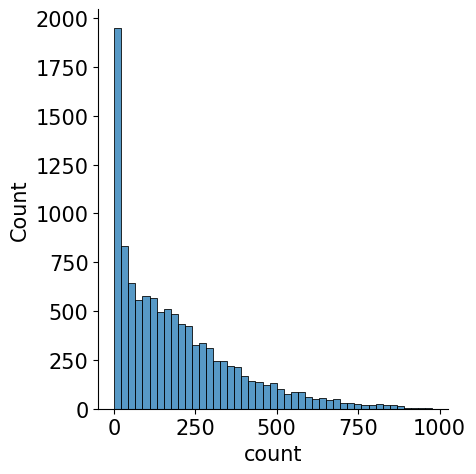

In [66]:
# date feature가 제공하는 정보는 모두 year, month, day feature에도 있어서 추후 date 피처는 제거한다.
# 또한 세 달씩 "월"을 묶으면 계절이 된다. 세분화된 month 피처를 세 달씩 묶으면 season피처와 의미가 같아진다. month를 제거한다.

# 그래프 시각화
import seaborn as sns, matplotlib as mlp, matplotlib.pyplot as plt
%matplotlib inline

# 타겟값의 분포도(수치형 데이터의 집계 값을 나타내는 그래프. 집계값 : 총 개수 or 비율)를 그려본다. 타겟값의 분포를 알면 훈련 시 타겟값을 그대로 사용할지 변환해 사용할지 파악할 수 있다.
mlp.rc("font", size=15) # fontsize 조절
sns.displot(train_data['count']) # 분포도 출력

# x축은 타겟값은 count를 나타내고, y축은 그 총 개수를 나타낸다. 분포도를 살펴보면 count가 0 근처에 몰려있다. 분포가 왼쪽으로 많이 편향되어 있다는 것이다.
# 회귀 모델이 좋은 성능을 내려면 정규 분포를 따라야 하는데, 현재 타겟값 count의 경우 그 분포를 따르지 않는다.
# 데이터 분포를 정규 분포에 가깝게 만들기 위해 가장 많이 사용하는 방법은 로그 변환이다. 로그 변환은 아래 분포와 같이 왼쪽으로 편향되어 있을때 자주 사용한다.

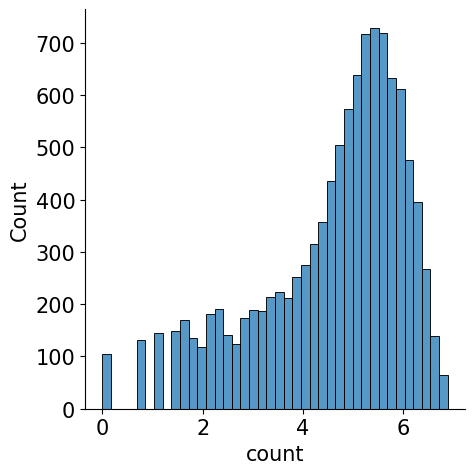

In [67]:
# 로그 변환
sns.displot(np.log(train_data['count']))
# 로그 변환하되, 마지막엔 지수 변환을 해서 실제 타겟값으로 복원해야 한다. 